In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [96]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-05 10:32:57,752 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-05 10:32:57,767 INFO: Initializing external client
2025-03-05 10:32:57,770 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 10:32:58,460 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215695


In [97]:
# Create a feature view if it doesn't already exist
# try:
#     feature_store.create_feature_view(
#         name=config.FEATURE_VIEW_NAME,
#         version=config.FEATURE_VIEW_VERSION,
#         query=feature_group.select_all(),
#     )
#     print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
# except Exception as e:
#     print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [98]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 


In [99]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [100]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2023-01-01 00:00:00+00:00,263,212
1,2023-01-01 01:00:00+00:00,263,242
2,2023-01-01 02:00:00+00:00,263,183
3,2023-01-01 03:00:00+00:00,263,123
4,2023-01-01 04:00:00+00:00,263,53


In [101]:
ts_data["pickup_hour"].min()

'2023-01-01 00:00:00+00:00'

In [102]:
ts_data["pickup_hour"].max()

'2023-12-31 23:00:00+00:00'

In [103]:
ts_data_copy = ts_data.copy()

In [104]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [105]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   pickup_hour         8760 non-null   datetime64[ns, UTC]
 1   pickup_location_id  8760 non-null   int32              
 2   rides               8760 non-null   int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 137.0 KB


In [106]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [107]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         8760 non-null   datetime64[ns]
 1   pickup_location_id  8760 non-null   int32         
 2   rides               8760 non-null   int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 137.0 KB


In [108]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [109]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,263,212,2023-01
1,2023-01-01 01:00:00,263,242,2023-01
2,2023-01-01 02:00:00,263,183,2023-01
3,2023-01-01 03:00:00,263,123,2023-01
4,2023-01-01 04:00:00,263,53,2023-01
...,...,...,...,...
8755,2023-12-31 19:00:00,263,188,2023-12
8756,2023-12-31 20:00:00,263,198,2023-12
8757,2023-12-31 21:00:00,263,232,2023-12
8758,2023-12-31 22:00:00,263,160,2023-12


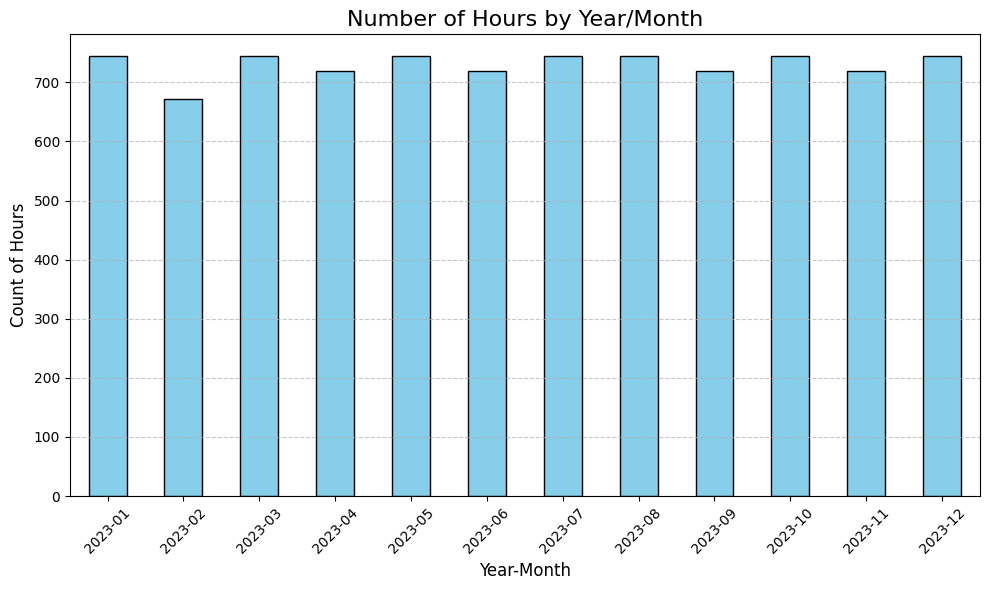

In [110]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [111]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,263,212,2023-01
1,2023-01-01 01:00:00,263,242,2023-01
2,2023-01-01 02:00:00,263,183,2023-01
3,2023-01-01 03:00:00,263,123,2023-01
4,2023-01-01 04:00:00,263,53,2023-01


In [112]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [113]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [114]:
filtered_data.shape

(8760, 3)

In [115]:
ts_data = filtered_data

In [116]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         8760 non-null   datetime64[ns]
 1   pickup_location_id  8760 non-null   int32         
 2   rides               8760 non-null   int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 137.0 KB


In [117]:
ts_data.head()["pickup_hour"].values

array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', '2023-01-01T03:00:00.000000000',
       '2023-01-01T04:00:00.000000000'], dtype='datetime64[ns]')

In [118]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [119]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,212,242,183,123,53,22,21,24,24,46,...,131,162,169,180,151,157,149,167,2023-01-29 00:00:00,263
1,37,25,16,10,4,12,8,19,28,39,...,123,124,128,111,84,89,59,86,2023-01-29 23:00:00,263
2,60,25,20,7,11,3,8,22,57,108,...,102,106,93,111,104,94,87,65,2023-01-30 22:00:00,263
3,68,55,26,15,2,3,6,6,13,58,...,115,101,98,114,118,128,110,99,2023-01-31 21:00:00,263
4,100,93,70,39,26,11,8,7,6,20,...,104,95,124,123,111,116,183,127,2023-02-01 20:00:00,263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,110,115,101,125,129,137,109,137,132,89,...,8,38,37,68,74,98,85,89,2023-12-27 13:00:00,263
348,104,109,89,133,130,143,165,103,106,111,...,8,14,30,34,49,76,96,88,2023-12-28 12:00:00,263
349,100,114,110,117,134,130,188,250,173,142,...,9,8,11,38,46,55,73,73,2023-12-29 11:00:00,263
350,151,148,147,134,119,137,124,126,160,205,...,36,13,14,16,20,25,42,54,2023-12-30 10:00:00,263


In [120]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id


In [121]:
features_copy = features.copy()

In [122]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(352, 675)

In [123]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-05 10:33:55.649236')

In [124]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(352, 674)
(352,)
(0, 674)
(0,)


In [125]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 1.8 MB


In [126]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [127]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57917
[LightGBM] [Info] Number of data points in the train set: 352, number of used features: 675
[LightGBM] [Info] Start training from score 82.068182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x00000205DA18CD60>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [128]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [129]:
predictions

array([127.32069758,  37.61197881,  57.19161786,  93.99424099,
       113.76317254, 137.88943332, 197.84993923, 128.17782714,
       115.81642329,  98.74124255, 122.38744766,  90.25092598,
       119.22357138, 125.3954079 , 142.37764261,  86.85534291,
       120.37671868, 115.84468926,  63.04719595,  18.40197007,
        16.43218663,  32.06205348,  54.45820002,   8.8289245 ,
        16.02144344,  30.64829838,  71.80475536, 114.55313364,
       191.20692839, 179.75281479, 110.91159382, 116.3199811 ,
        96.86136778, 127.39791293, 118.11599643, 123.53294061,
       155.11544457, 107.42215148, 109.18938361, 122.98304283,
       132.77116668, 116.15706698,  55.37273584,   9.09838207,
        30.04271811,   8.06319701,   4.92981122,  11.5434091 ,
        23.02801106,  73.25598683, 194.39432788, 173.80252626,
       106.40048377,  97.27008381,  92.80450541, 117.65122094,
        93.28332519, 112.1808303 , 131.50815799, 115.37115131,
        88.3284611 , 102.80466568, 122.66931838, 142.20

In [130]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

1.1669


In [131]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['D:\\BHAVYA KHILRANI\\Documents\\sp25_taxi-main\\models\\lgb_model.pkl']

In [132]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [133]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    # include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
model.save(config.MODELS_DIR + '/' + 'lgb_model.pkl')

TypeError: unsupported operand type(s) for +: 'WindowsPath' and 'str'

In [40]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-02-10 22:39:54,780 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-02-10 22:39:54,790 INFO: Initializing external client
2025-02-10 22:39:54,790 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-02-10 22:39:55,824 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1211551

In [92]:
from src.inference import get_model_predictions

In [93]:
preds = get_model_predictions(model, features_copy)

AttributeError: 'Model' object has no attribute 'predict'

In [46]:
model.get_m

AttributeError: 'Model' object has no attribute 'get_m'

In [47]:
preds

NameError: name 'preds' is not defined

In [47]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

1.8374
